In [3]:
import pandas as pd
import importlib
from IPython.display import Audio
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sys
import soundfile as sf

In [146]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages")

print("Path to dataset files:", path)

100%|██████████| 17.9G/17.9G [26:51<00:00, 11.9MB/s]  


Extracting files...
Path to dataset files: C:\Users\ROHAN\.cache\kagglehub\datasets\hbchaitanyabharadwaj\audio-dataset-with-10-indian-languages\versions\1


In [4]:
import os
fld = "D:/Sem3/Speech/Assignments/Assignment2/Data/Languages/Language Detection Dataset"
langdf = pd.DataFrame(columns=['lang', 'path'])
lst = []
for root, dirs, files in os.walk(fld):
  if os.path.basename(root) == os.path.basename(fld):
    continue
  folderNm = os.path.basename(root)
  print(folderNm)
  lst = lst + [{'lang': folderNm, 'path': os.path.join(fld,folderNm,f)} for f in files]

langdf = pd.DataFrame(lst)

Bengali
Gujarati
Hindi
Kannada
Malayalam
Marathi
Punjabi
Tamil
Telugu
Urdu


In [5]:
del lst

In [12]:
# import torchaudio
from pydub import AudioSegment
def getMFCC(file_path):
    audio = AudioSegment.from_file(file_path, format="mp3")
    audio.export("converted.wav", format="wav")
    y, sr = librosa.load("converted.wav", sr=None)#torchaudio.load(file_path, format='mp3', backend='ffmpeg')
    s = librosa.feature.melspectrogram(y=y, sr=sr)
    return s

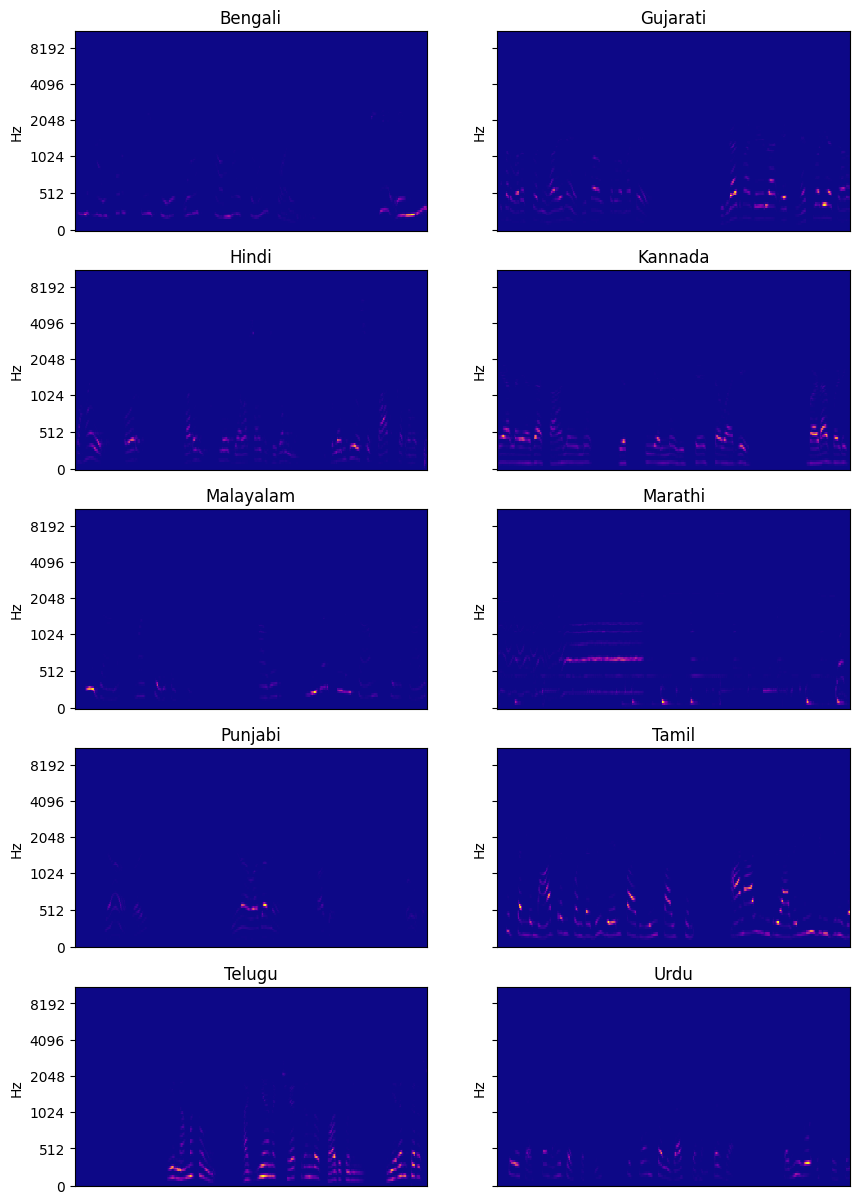

In [19]:
langsampleLst = langdf.groupby("lang").sample(n=1, random_state=1).values.tolist()

fig, axs = plt.subplots(5, 2, sharey=True)
fig.set_size_inches(10,15)
allAx = axs.flat
# baseLen = 100*60
# plt.figure(figsize=(10, 4))
# basePath = "./Q1/"
for ax, f in zip(allAx,langsampleLst):
    lang, file_path = f
    # fzcr, fste, fmfccs, ffrcount = featureExtractor(fnm)
    # librosa.display.specshow(fmfccs, ax=ax)
    audio = AudioSegment.from_file(file_path, format="mp3")
    audio.export("converted.wav", format="wav")
    y, sr = librosa.load("converted.wav", sr=None)#torchaudio.load(file_path, format='mp3', backend='ffmpeg')
    s = librosa.feature.melspectrogram(y=y, sr=sr)
    # D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    # librosa.display.specshow(D, x_axis='time',y_axis="log", ax=ax)
    librosa.display.specshow(s, ax=ax, y_axis='mel', cmap='plasma')
    ax.set_title(lang)
    # ax.set_xlabel('Time')
    # ax.set_ylabel('Frequency')

In [13]:
import numpy as np
sampledf = langdf.groupby("lang").sample(n=1000, random_state=1)
sampledf['mel'] = sampledf.apply(lambda r: getMFCC(r['path']), axis = 1)
sampledf['dimSize'] = sampledf.apply(lambda r: np.array(r['mel']).shape[1], axis = 1)
sampledf = sampledf.loc[sampledf["dimSize"]>=400]
sampledf['newmel'] = sampledf.apply(lambda r: np.mean(np.array(r['mel'])[:,:400], axis=1).T, axis = 1)
sampledf.reset_index(drop=True, inplace=True)
# sampledf['shape'] = sampledf['newmel'].apply(lambda x: x.shape)

tdfMean = sampledf.groupby('lang')['newmel'].agg(np.mean)
tdfVar = sampledf.groupby('lang')['newmel'].apply(lambda x: np.var(np.stack(x.to_numpy()), axis=0))

C:\Users\ROHAN\AppData\Local\Temp\ipykernel_14492\2703893692.py:9: FutureWarning: The provided callable <function mean at 0x000001FF39A789A0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  tdfMean = sampledf.groupby('lang')['newmel'].agg(np.mean)


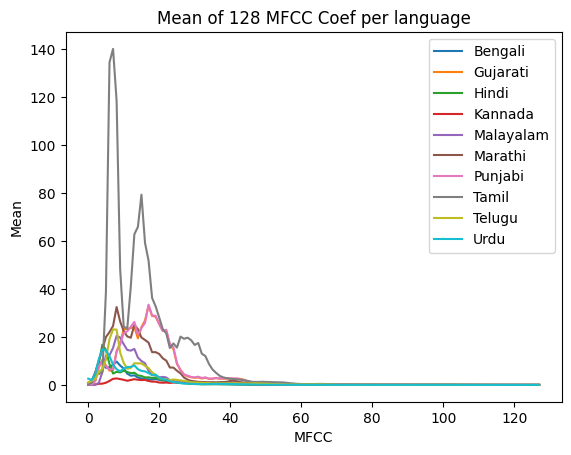

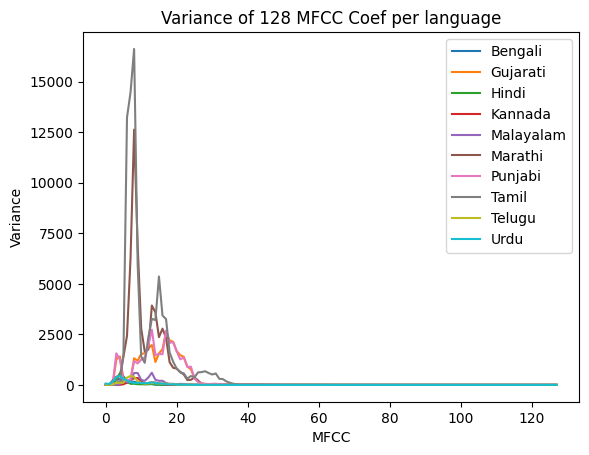

In [131]:
# tdf.loc['Hindi'].shape
means = tdfMean.to_dict()
vars = tdfVar.to_dict()

# means['Hindi'].shape
for k, m in means.items():
    plt.plot(m, label=k)

plt.title('Mean of 128 MFCC Coef per language')
plt.xlabel('MFCC')
plt.ylabel('Mean')
plt.legend()
plt.show()

for k, v in vars.items():
    plt.plot(v, label=k)

plt.title('Variance of 128 MFCC Coef per language')
plt.xlabel('MFCC')
plt.ylabel('Variance')
plt.legend()
plt.show()
# means

In [14]:
idxLst = list(tdfMean.index)
sampledf['aud_id'] = sampledf['lang'].apply(lambda x: idxLst.index(x))
sampledf['melflat'] = sampledf.apply(lambda r:  np.array(r['mel'])[:,:400].flatten(), axis = 1)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

fdf = sampledf['melflat'].values.tolist()
X_train, X_test, y_train, y_test = train_test_split(fdf, sampledf['aud_id'], test_size=0.2, random_state=45, stratify=sampledf['aud_id'])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# classifier = SVC(kernel='rbf', random_state=45, decision_function_shape='ovo')
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)

# calc_classification_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
# print("Classification Report:\n", calc_classification_report)

# calc_confusion_matrix = confusion_matrix(y_test, y_pred)
# print("Confusion matrix:\n", calc_confusion_matrix)

# plt.figure(figsize=(6, 5))
# sns.heatmap(calc_confusion_matrix, annot=True, cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='g')
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix (KNN)") 
# plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



# print("\nDataset Sizes:")
# print(f"Total samples: {len(X)}")
# print(f"Training set size: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
# print(f"Test set size: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
# print(f"Number of features: {X_train.shape[1]}")

Accuracy: 75.93%

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.80      0.74       200
           1       0.43      0.37      0.40       199
           2       0.86      0.95      0.91       200
           3       0.99      0.90      0.95       143
           4       0.90      0.92      0.91       163
           5       0.90      0.78      0.84       200
           6       0.44      0.41      0.42       200
           7       0.88      0.81      0.84       199
           8       0.89      0.89      0.89       200
           9       0.70      0.83      0.76       199

    accuracy                           0.76      1903
   macro avg       0.77      0.77      0.76      1903
weighted avg       0.76      0.76      0.76      1903



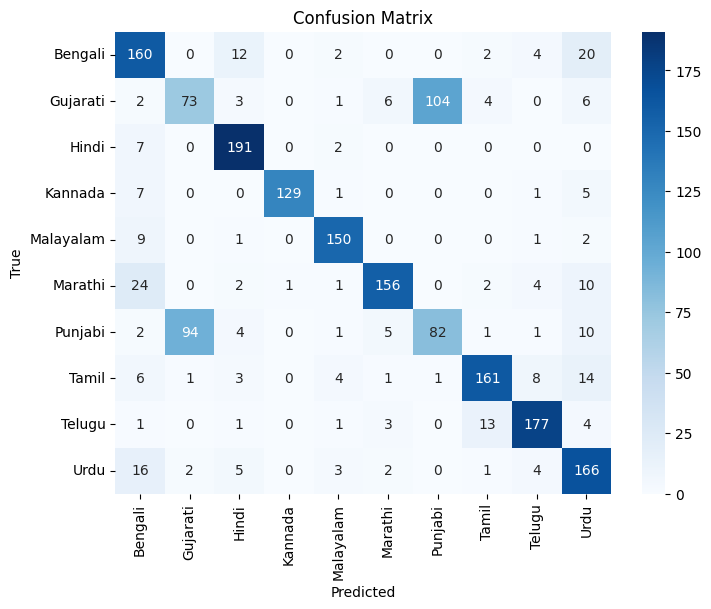

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=None)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idxLst, yticklabels=idxLst)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()